In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table

from scipy.odr import ODR, Model, RealData

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)

from src.utils.constants import *
from src.utils.CosmoFunc import *
from src.utils.functions import density_contour

def bin_data(x: np.array, y: np.array, n_bin: int, window_size: float):
    # x_bin = np.linspace(np.min(x), np.max(x), n_bin)
    x_bin = np.linspace(0.00475, 0.05377, n_bin)

    x_bin_ = []
    y_bin = []
    y_bin_err = []
    y_bin_stderr = []

    for x_trial in x_bin:
        x_lower = x_trial - window_size
        x_upper = x_trial + window_size

        y_ = y[(x >= x_lower) & (x <= x_upper)]

        if len(y_):
            x_bin_.append(x_trial)
            y_bin.append(np.median(y_))
            y_bin_err.append(np.std(y_))
            y_bin_stderr.append(np.std(y_) / np.sqrt(len(y_)))
        else:
            continue

    return x_bin_, y_bin, y_bin_err, y_bin_stderr

In [29]:
# Load Cullan's data
df_h22 = pd.read_csv("../../data/external/logdist/cullan_logdist.csv")
df_h22["objid"] = df_h22["objid"].apply(lambda x: "SDSS" + str(x))
df_h22 = df_h22[df_h22["zcmb_group"] <= ZMAX]

# Load my SDSS data
req_cols = ["tmass", "objid", "zhelio", "z_cmb", "z_dist_est", "j_m_ext", "extinction_j", "kcor_j", "logdist_sdss", "logdist_err_sdss", "logdist_all_combined", "logdist_err_all_combined"]
df_sdss = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")[req_cols]

# Combine the two dataset
df = df_h22.merge(df_sdss, on="objid", how="left")

# Add flag: True if has 2MASS counterpart
df["tmass_counterpart"] = (~df["tmass"].isnull()).astype(int)
df["i_temp"] = df["s"]
df["s_temp"] = df["i"]
df.drop(["i", "s"], axis=1, inplace=True)
df.rename({"i_temp": "i", "s_temp": "s"}, axis=1, inplace=True)

df.head()

,PGC,coords,objid,specObjId,plate,RA,Dec,l,b,deVMag_g,...,j_m_ext,extinction_j,kcor_j,logdist_sdss,logdist_err_sdss,logdist_all_combined,logdist_err_all_combined,tmass_counterpart,i,s
0,2180626,J161531.4+412425,SDSS1237659329777107022,1318559404106213120,1171,243.880668,41.407020,65.575776,46.176954,15.44160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3.32697,2.29344
1,1202881,J120049.3+014137,SDSS1237651752936669345,581023484520458240,516,180.205594,1.693724,275.307612,61.820046,16.37174,...,13.496,0.016758,-0.033756,-0.181149,0.103752,-0.197525,0.104839,1,2.60288,2.31628
2,2390396,J121711.0+511256,SDSS1237658206121951256,1092266436388218752,970,184.296053,51.215516,135.708833,65.054699,16.24372,...,13.573,0.019936,-0.025538,-0.125335,0.103628,-0.142033,0.104727,1,2.21712,2.22337
3,25140,J085646.5+564712,SDSS1237651272963326121,504552173967796160,448,134.193871,56.786748,160.207295,39.420629,15.65960,...,12.806,0.019476,-0.023957,-0.054257,0.092820,-0.063292,0.093275,1,2.84745,2.21956
4,2365804,J103511.2+501150,SDSS1237657857677787357,985281205236688768,875,158.796476,50.197076,161.986100,55.314055,17.01564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2.44682,2.03029


# Check: Univariate observable distributions

## Distribution of FP observables + redshift + magnitude

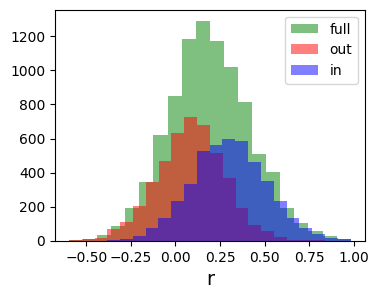

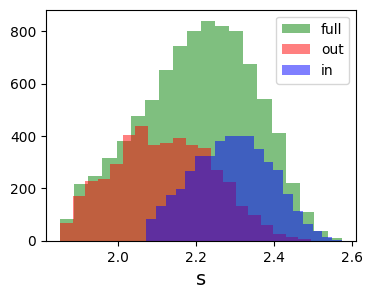

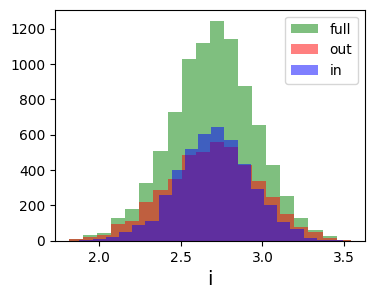

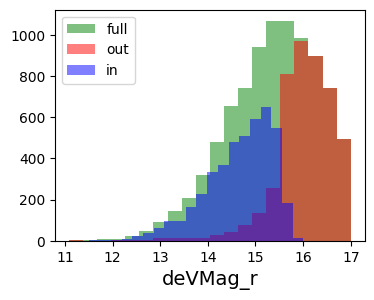

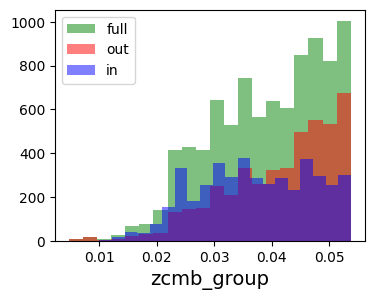

In [30]:
dict_ = {
    0: {
        "color": "red",
        "label": "out"
    },
    1: {
        "color": "blue",
        "label": "in"
    }
}
cols = ["r", "s", "i", "deVMag_r", "zcmb_group"]

for i, col in enumerate(cols):

    plt.figure(figsize=(4, 3))
    plt.xlabel(col, fontsize=14)
    plt.hist(df[col], color="green", bins=20, alpha=0.5, label="full")

    for j in [0, 1]:
        df_ = df.copy()
        df_ = df_[df_["tmass_counterpart"] == j]
        
        plt.hist(df_[col], color=dict_[j]["color"], bins=20, alpha=0.5, label=dict_[j]["label"])

    plt.legend()

# Check: Bivariate observable distributions

## Distribution of 2D FP

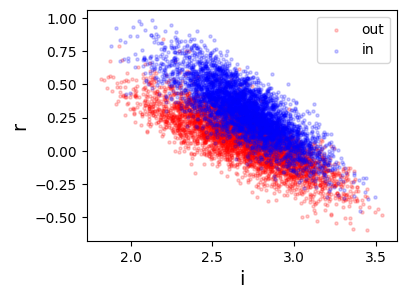

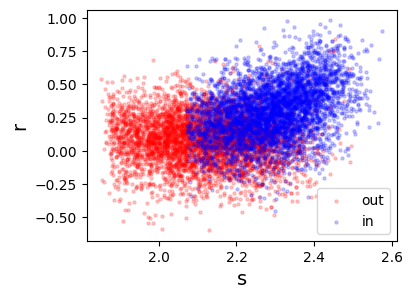

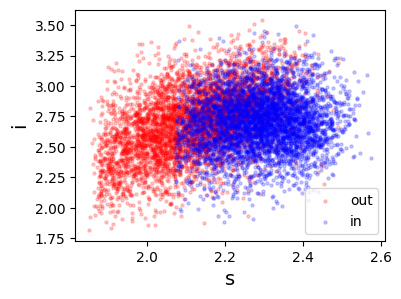

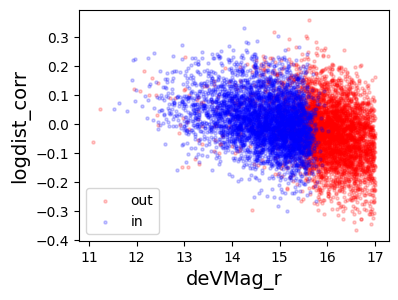

In [3]:
dict_ = {
    0: {
        "color": "red",
        "label": "out"
    },
    1: {
        "color": "blue",
        "label": "in"
    }
}
combos = [("i", "r"), ("s", "r"), ("s", "i"), ("deVMag_r", "logdist_corr")]

for i, combo in enumerate(combos):

    x, y = combo

    plt.figure(figsize=(4, 3))
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)

    for j in [0, 1]:
        df_ = df.copy()
        df_ = df_[df_["tmass_counterpart"] == j]
        
        plt.scatter(df_[x], df_[y], color=dict_[j]["color"], s=5, alpha=0.2, label=dict_[j]["label"])

    plt.legend()

# r vs J magnitude

Text(0, 0.5, 'J magnitude')

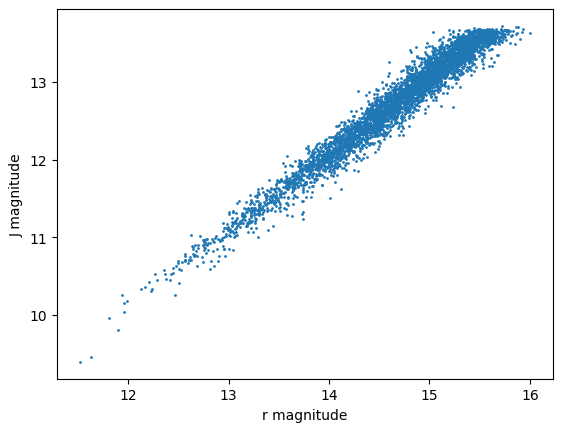

In [39]:
plt.scatter(df["deVMag_r"], df["j_m_ext"], s=1)
plt.xlabel("r magnitude")
plt.ylabel("J magnitude")

Missing galaxies where r mag > 15.5. If the sample is complete at r = 17.0, a J-band cut of 13.65 should also be complete?

# Absolute magnitude

4515
4408


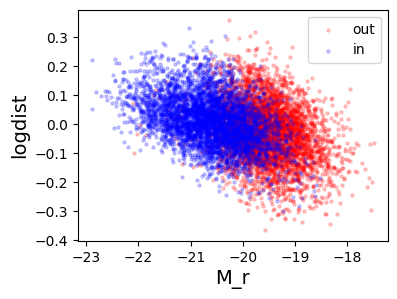

In [59]:
dict_ = {
    0: {
        "color": "red",
        "label": "out"
    },
    1: {
        "color": "blue",
        "label": "in"
    }
}

# Calculate J-band absolute magnitude
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
d_C = sp.interpolate.splev(df["zcmb_group"].to_numpy(), dist_spline)
d_L = (1 + df["zhelio_x"]) * d_C * 10**6
df["absMag_r"] = (df["deVMag_r"] - df["extinction_r"]) - 5 * (np.log10(d_L) - 1) - df["kcor_r"]

plt.figure(figsize=(4, 3))
plt.xlabel("M_r", fontsize=14)
plt.ylabel("logdist", fontsize=14)
# plt.scatter(df["absMag_r"], df["logdist_corr"], s=5)

for j in [0, 1]:
    df_ = df.copy()
    df_ = df_[df_["tmass_counterpart"] == j]
    print(len(df_))
    
    plt.scatter(df_["absMag_r"], df_["logdist_corr"], color=dict_[j]["color"], s=5, alpha=0.2, label=dict_[j]["label"])

plt.legend()

In [54]:
df

,PGC,coords,objid,specObjId,plate,RA,Dec,l,b,deVMag_g,...,j_m_ext,extinction_j,kcor_j,logdist_sdss,logdist_err_sdss,logdist_all_combined,logdist_err_all_combined,tmass_counterpart,absMag_j,absMag_r
0,2180626,J161531.4+412425,SDSS1237659329777107022,1318559404106213120,1171,243.880668,41.407020,65.575776,46.176954,15.44160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
1,1202881,J120049.3+014137,SDSS1237651752936669345,581023484520458240,516,180.205594,1.693724,275.307612,61.820046,16.37174,...,13.496,0.016758,-0.033756,-0.181149,0.103752,-0.197525,0.104839,1,-20.402077,-20.402077
2,2390396,J121711.0+511256,SDSS1237658206121951256,1092266436388218752,970,184.296053,51.215516,135.708833,65.054699,16.24372,...,13.573,0.019936,-0.025538,-0.125335,0.103628,-0.142033,0.104727,1,-20.489022,-20.489022
3,25140,J085646.5+564712,SDSS1237651272963326121,504552173967796160,448,134.193871,56.786748,160.207295,39.420629,15.65960,...,12.806,0.019476,-0.023957,-0.054257,0.092820,-0.063292,0.093275,1,-19.680387,-19.680387
4,2365804,J103511.2+501150,SDSS1237657857677787357,985281205236688768,875,158.796476,50.197076,161.986100,55.314055,17.01564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8918,2155907,J162858.8+394811,SDSS1237655471820701863,1319692450939299840,1172,247.245235,39.803056,63.284681,43.634451,15.95666,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
8919,56786,J160218.0+162158,SDSS1237665531723317440,2472613143914768384,2196,240.575050,16.366201,29.418294,44.669599,15.29424,...,12.223,0.025590,-0.023069,-0.065384,0.096146,-0.077575,0.096799,1,-21.087230,-21.087230
8920,58348,J162944.9+404842,SDSS1237655373573062713,919958120371873792,817,247.437155,40.811611,64.680181,43.506581,12.81371,...,10.256,0.004429,-0.022119,0.219438,0.085507,0.211229,0.085631,1,-22.839784,-22.839784
8921,58191,J162741.1+405537,SDSS1237655472357114000,918822324826826880,816,246.921342,40.926966,64.835897,43.897452,13.70092,...,10.762,0.004307,-0.020473,0.090851,0.087623,0.080309,0.087928,1,-21.998176,-21.998176


Index(['PGC', 'coords', 'objid', 'specObjId', 'plate', 'RA', 'Dec', 'l', 'b',
       'deVMag_g', 'deVMagErr_g', 'deVMag_r', 'deVMagErr_r', 'deVRad_r',
       'deVRadErr_r', 'deVAB_r', 'deVABErr_r', 'extinction_g', 'extinction_r',
       'kcor_r', 'kcor_g', 'absmag_r', 'zhelio', 'zhelioerr', 'zcmb',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'IDgroupT17', 'NgroupT17',
       'zcmb_group', 'M', 'in_mask', 'nbar', 'r', 'er', 'i', 'ei', 's', 'es',
       'Sn', 'logdist', 'logdist_err', 'logdist_alpha', 'logdist_corr',
       'logdist_corr_err', 'logdist_corr_alpha'],
      dtype='object')


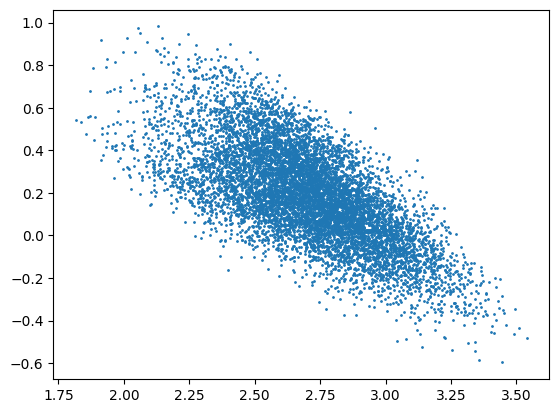

In [20]:
df = pd.read_csv("../../../../../Downloads/SDSS_PV_public.dat", delim_whitespace=True)
df = df[df["zcmb_group"] <= ZMAX]

print(df.columns)

plt.scatter(df["i"], df["r"], s=1)

Index(['PGC', 'coords', 'objid', 'specObjId', 'plate', 'RA', 'Dec', 'l', 'b',
       'deVMag_g', 'deVMagErr_g', 'deVMagErr_r', 'deVMagErr_r.1', 'deVRad_r',
       'deVRadErr_r', 'deVAB_r', 'deVABErr_r', 'extinction_g', 'extinction_r',
       'kcor_r', 'kcor_g', 'absmag_r', 'zhelio', 'zhelioerr', 'zcmb',
       'SIGMA_STARS', 'SIGMA_STARS_ERR', 'IDgroupT17', 'NgroupT17',
       'zcmb_group', 'M', 'in_mask', 'nbar', 'r', 'er', 's', 'es', 'i', 'ei',
       'logdist', 'logdist_err', 'logdist_alpha', 'logdist_corr',
       'logdist_corr_err', 'logdist_corr_alpha'],
      dtype='object')


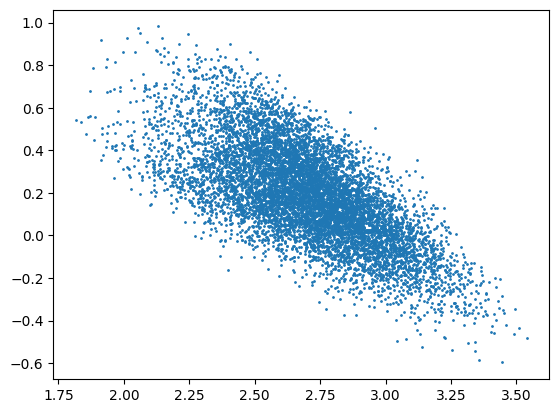

In [21]:
df = pd.read_csv("../../../../../Downloads/SDSS_PV_public_full_reformat.dat", delim_whitespace=True)
df = df[df["zcmb_group"] <= ZMAX]

print(df.columns)

plt.scatter(df["s"], df["r"], s=1)

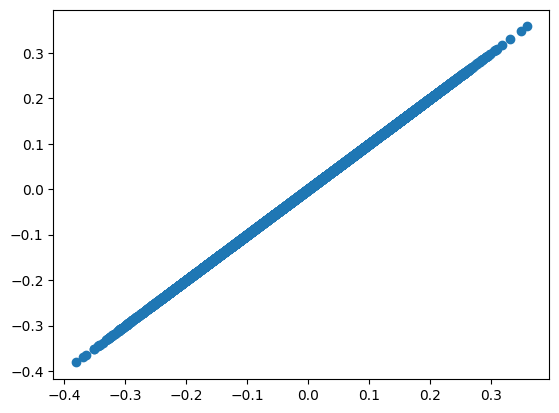

In [23]:
df_1 = pd.read_csv("../../../../../Downloads/SDSS_PV_public.dat", delim_whitespace=True)[["objid", "logdist_corr"]]
# df = df[df["zcmb_group"] <= ZMAX]

df_2 = pd.read_csv("../../../../../Downloads/SDSS_PV_public_full_reformat.dat", delim_whitespace=True)[["objid", "logdist_corr"]]
# df = df[df["zcmb_group"] <= ZMAX]

df = df_1.merge(df_2, on="objid")

plt.scatter(df["logdist_corr_x"], df["logdist_corr_y"])

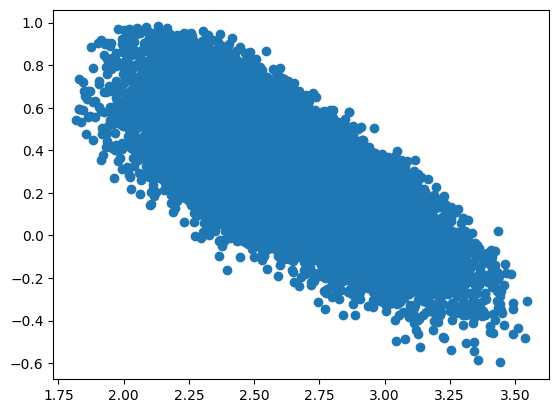

In [27]:
df = pd.read_csv("../../../../../Downloads/EDDtable28Feb2025012546.txt")

plt.scatter(df["i"], df["r"])